In [1]:
import pandas as pd
import utils
import matplotlib.pyplot as plt
import os
import dataloader

import torch
import torch.nn as nn
from model import generate_model

from torch.utils.data import DataLoader
from metrics import accuracy

In [2]:
dir_path ='result/' 
result_name = ['resnet18_20221120_0337','resnet18_20221121_0001'] #selector

selector = 1

result_path = os.path.join(dir_path,result_name[selector])
df_train_log = pd.read_csv(os.path.join(result_path,result_name[selector]+'_train.log'),delimiter='\t')
df_valid_log = pd.read_csv(os.path.join(result_path,result_name[selector]+'_valid.log'),delimiter='\t')
df_test_log = pd.read_csv(os.path.join(result_path,result_name[selector]+'_test.log'),delimiter='\t')

model_last_path = os.path.join(result_path,result_name[selector]+'_checkpoint.pth')
model_best_path = os.path.join(result_path,result_name[selector]+'_best.pth')

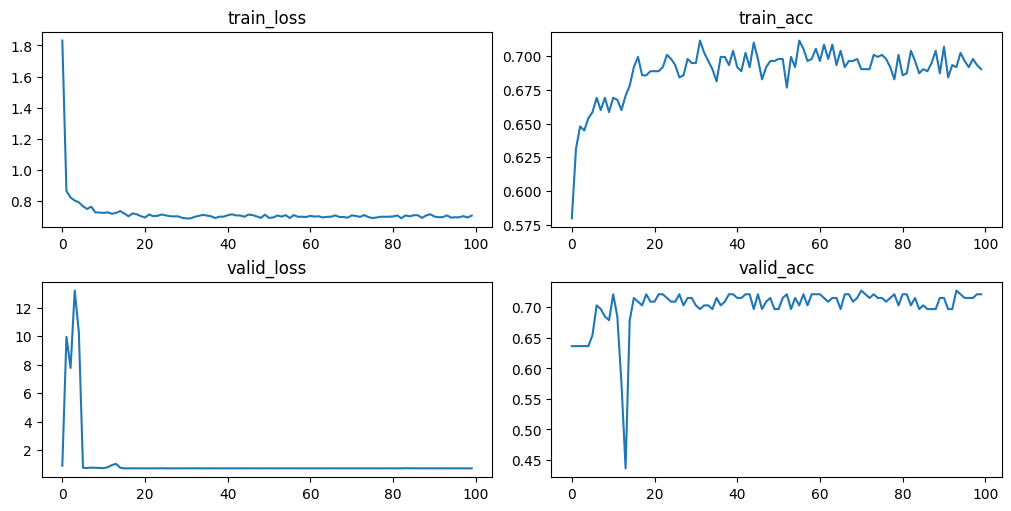

In [3]:
fig,ax = plt.subplots(2,2,figsize=[10,5],constrained_layout=True)
#plt.suptitle('title')
ax[0,0].set_title('train_loss')
ax[0,0].plot(df_train_log['loss'])
ax[0,1].set_title('train_acc')
ax[0,1].plot(df_train_log['acc'])
ax[1,0].set_title('valid_loss')
ax[1,0].plot(df_valid_log['loss'])
ax[1,1].set_title('valid_acc')
ax[1,1].plot(df_valid_log['acc'])

In [4]:
from model_test import test

In [5]:
#데이터셋 분리(Train, validation, test)
config = utils.load_config()

df_dataset = pd.read_csv(config['PATH_DATASET_CSV'])
df_dataset = df_dataset.dropna().reset_index(drop=True)
df_oasis = df_dataset[df_dataset['source'] == 'OASIS-3']
df_adni = df_dataset[df_dataset['source'] == 'ADNI']
X_train,X_val,y_train,y_val = dataloader.dataset_split(df_oasis,test_size=0.2,shuffle=True,grp=None,seed=1004)
X_test = df_adni.drop(labels='group_maxinc',axis=1)
y_test = df_adni['group_maxinc']

traindata=dataloader.MRIDataset(X_train,y_train)
valdata=dataloader.MRIDataset(X_val,y_val)
testdata=dataloader.MRIDataset(X_test,y_test)

from torch.utils.data import DataLoader
train_dataloader = DataLoader(traindata, batch_size=1, shuffle=True,num_workers=1)
val_dataloader  = DataLoader(valdata, batch_size=1, shuffle=False,num_workers=1)
test_dataloader  = DataLoader(testdata, batch_size=1, shuffle=False,num_workers=4)

print('train_dataloader : ',len(train_dataloader.dataset))
print('val_dataloader : ',len(val_dataloader.dataset))
print('test_dataloader : ',len(test_dataloader.dataset))

train_dataloader :  659
val_dataloader :  165
test_dataloader :  166


/Users/shin/MyDir/MyGit/BrainMR_MCI/dataloader.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset['grp'] = (df_dataset['source'].str.replace('OASIS-3','1').str.replace('ADNI','2').apply(pd.to_numeric)*1000


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model, _ = generate_model(model_name='resnet',model_depth = 18,n_classes=3,resnet_shortcut='B',add_last_fc_num=1)
model.to(device)

log_path = config['log_path']
criterion_clf = nn.CrossEntropyLoss().to(device)

checkpoint = torch.load(model_best_path, map_location=device)
model.load_state_dict(checkpoint['state_dict'])

/Users/shin/MyDir/MyGit/BrainMR_MCI/models/resnet.py:143: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


cpu


<All keys matched successfully>

In [7]:
outputs = []
labels = []
with torch.no_grad():
    for i, (inputs,age, targets) in enumerate(test_dataloader):
        model.eval()
        output = model(inputs,age)
        outputs.append(output[0].data.cpu())
        labels.append(targets[0].data.cpu())
        acc = accuracy(output.data, targets.data,device=device)
        
outputs = torch.stack(outputs)
labels =  torch.stack(labels)

In [ ]:
from torchmetrics.classification import MulticlassConfusionMatrix,MulticlassROC
roc_metric = MulticlassROC(num_classes=3, thresholds=None).to(device)
fpr, tpr, thresholds = roc_metric(outputs, labels)

In [ ]:
_fpr = []
_tpr = []
_thresholds = []
for i in range(3):
    _fpr.append(fpr[0].tolist())
    _tpr.append(tpr[0].tolist())
    _thresholds.append(thresholds[0].tolist())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


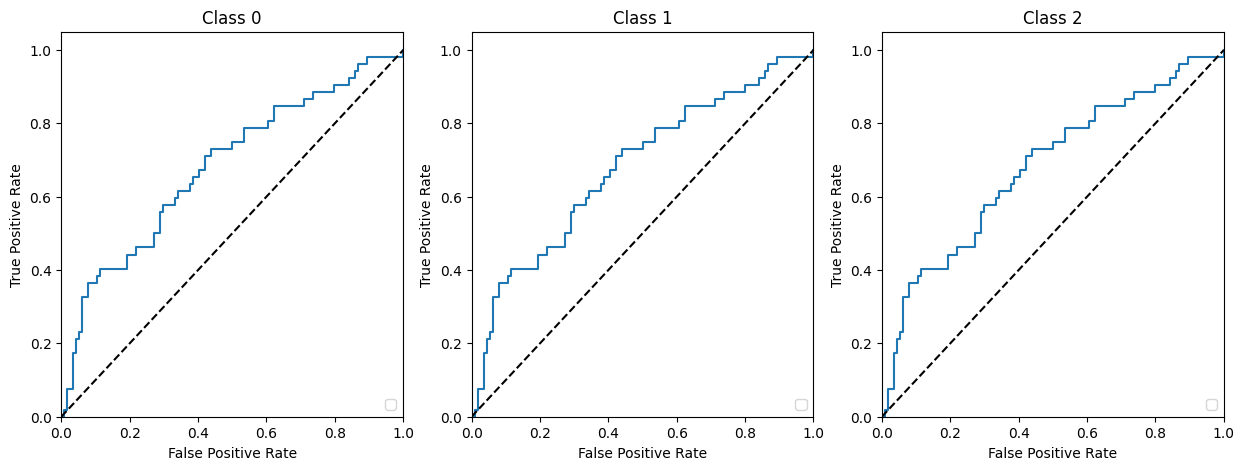

In [ ]:
# Plot of a ROC curve for a specific class
plt.figure(figsize=(15, 5))
for idx, i in enumerate(range(3)):
    plt.subplot(131+idx)
    plt.plot(_fpr[i], _tpr[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Class %0.0f' % idx)
    plt.legend(loc="lower right")
plt.show()

In [ ]:
from torchmetrics.functional.classification import multiclass_auroc
auc = multiclass_auroc(outputs, labels, num_classes=3, average=None, thresholds=None)

In [ ]:
auc.tolist()
#[0.6801619529724121, 0.6081395149230957, 0.653743326663971]

[0.6801619529724121, 0.6081395149230957, 0.653743326663971]